In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load our data**

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Classes:", train_dataset.classes)
print('Training set has {} instances'.format(len(train_dataset)))
print('Validation set has {} instances'.format(len(test_dataset)))


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.34MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Training set has 60000 instances
Validation set has 10000 instances


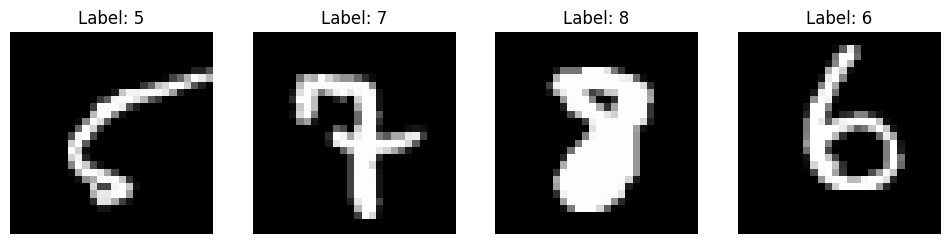

In [5]:
# get batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    ax = axes[i]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {labels[i].item()}")
plt.show()

In [6]:
print('Training set; {} samples'.format(len(train_dataset)))
print('Validation set; {} samples'.format(len(test_dataset)))

Training set; 60000 samples
Validation set; 10000 samples


**EXECISE 1: FEED FORWARD FULLY CONNECTED NN**

Initializing linear model with layers $$\textbf{f}[\textbf{x},\boldsymbol\phi]=\boldsymbol\Omega\cdot \textbf{x} + \boldsymbol\beta$$
$$\boldsymbol\phi = \{\boldsymbol\Omega_i,\beta_i\}_{i=1}^{I}$$
and activations $$\textbf{h}[\textbf{f}[\textbf{x},\boldsymbol\phi]]=\text{ReLU}[z]=\text{max}[0,z]$$
output
$$\text{softmax}_k[f]=\frac{e^f}{\sum_{j}e^{f_j}}$$

In [ ]:
class FeedForwardNN(nn.Module):
    def __init__(self, K, D, D_i, D_o):
        super(FeedForwardNN, self).__init__()
        layers = []

        # input layer
        if K == 0:
            layers.append(nn.Linear(D_i, D_o))
        else:
            layers.append(nn.Linear(D_i, D))
            layers.append(nn.ReLU())

            # hidden layers
            for _ in range(K - 1):
                layers.append(nn.Linear(D, D))
                layers.append(nn.ReLU())

            # output layer
            layers.append(nn.Linear(D, D_o))

        self.model = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        #print(f' x shape = {print(x.shape)}')
        pred_probs = F.log_softmax(self.model(x.view(x.size(0), -1)), dim=1)  # softmax out
        #print(pred_probs.shape)
        return pred_probs



In [ ]:
D_i = 784
D = 512  # neurons per hidden layer
D_o = 10
K = 2
model = FeedForwardNN(K, D, D_i, D_o)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
model.to(device)
print(f'device = {device}')

device = cuda


In [ ]:
def train_one_epoch(epoch_index):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    num_batches = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)  # get index of max prob
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

        # print loss every 1000 its
        if (i + 1) % 1000 == 0:
            avg_batch_loss = running_loss / (i + 1)
            print(f'  Batch {i + 1}/{num_batches} - Loss: {avg_batch_loss:.4f}')


    avg_loss = running_loss / num_batches if num_batches > 0 else 0
    train_accuracy = 100. * correct_train / total_train if total_train > 0 else 0
    return avg_loss, train_accuracy


In [ ]:

import time

train_costs = []
test_costs = []
train_accuracies = []
test_accuracies = []

epoch_number = 0
EPOCHS = 50
best_vloss = float('inf')
model.to(device)

start = time.time()  # Corrected timing

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    # Training
    model.train()
    avg_loss, train_accuracy = train_one_epoch(epoch_number)
    train_costs.append(avg_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    running_vloss = 0.0
    correct_v = 0
    total_v = 0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata

            # Move validation data to device
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)

            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            # Calculate accuracy for validation
            _, predicted = voutputs.max(1)
            correct_v += predicted.eq(vlabels).sum().item()
            total_v += vlabels.size(0)

    avg_vloss = running_vloss / (i + 1)
    test_costs.append(avg_vloss)
    test_accuracy = 100. * correct_v / total_v
    test_accuracies.append(test_accuracy)

    print(f'LOSS train {avg_loss:.4f} valid {avg_vloss:.4f}')
    print(f'Accuracy train {train_accuracy:.2f}% valid {test_accuracy:.2f}%')

    # Save the best model
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_feb26_epoch{epoch_number}.pth'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

end = time.time()  # Corrected timing
print(f'Training completed in {end - start:.2f} seconds')

EPOCH 1:
LOSS train 0.3997 valid 0.2069
Accuracy train 88.09% valid 93.89%
EPOCH 2:
LOSS train 0.1866 valid 0.1555
Accuracy train 94.52% valid 95.33%
EPOCH 3:
LOSS train 0.1396 valid 0.1267
Accuracy train 95.92% valid 96.09%
EPOCH 4:
LOSS train 0.1122 valid 0.1077
Accuracy train 96.64% valid 96.77%
EPOCH 5:
LOSS train 0.0929 valid 0.0921
Accuracy train 97.30% valid 97.20%
EPOCH 6:
LOSS train 0.0791 valid 0.0927
Accuracy train 97.68% valid 97.02%
EPOCH 7:
LOSS train 0.0692 valid 0.0875
Accuracy train 98.01% valid 97.32%
EPOCH 8:
LOSS train 0.0600 valid 0.0843
Accuracy train 98.32% valid 97.32%
EPOCH 9:
LOSS train 0.0531 valid 0.0760
Accuracy train 98.42% valid 97.66%
EPOCH 10:
LOSS train 0.0471 valid 0.0713
Accuracy train 98.64% valid 97.79%
EPOCH 11:
LOSS train 0.0412 valid 0.0749
Accuracy train 98.84% valid 97.50%
EPOCH 12:
LOSS train 0.0372 valid 0.0694
Accuracy train 99.00% valid 97.98%
EPOCH 13:
LOSS train 0.0334 valid 0.0663
Accuracy train 99.10% valid 97.91%
EPOCH 14:
LOSS train 

In [ ]:
training_time = end - start

In [7]:
from matplotlib import pyplot as plt
import numpy as np
def training_curve_plot(title, train_costs, test_costs, train_accuracy, test_accuracy, batch_size, learning_rate, epochs, training_time):
    lg=18
    md=13
    sm=9
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, y=1.15, fontsize=lg)
    sub = f'| Batch size:{batch_size} | Learning rate:{learning_rate} | Number of Epochs:{epochs} | Training time:{training_time:.0f}s |'
    fig.text(0.5, 0.99, sub, ha='center', fontsize=md)
    x = range(1, len(train_costs)+1)
    axs[0].plot(x, train_costs, label=f'Final train cost: {train_costs[-1]:.4f}')
    axs[0].plot(x, test_costs, label=f'Final test cost: {test_costs[-1]:.4f}')
    axs[0].set_title('Costs', fontsize=md)
    axs[0].set_xlabel('Epochs', fontsize=md)
    axs[0].set_ylabel('Cost', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[1].plot(x, [acc / 100 for acc in train_accuracy], label=f'Final train accuracy: {train_accuracy[-1]:.2f}%')
    axs[1].plot(x, [acc / 100 for acc in test_accuracy], label=f'Final test accuracy: {test_accuracy[-1]:.2f}%')
    axs[1].set_title('Accuracy', fontsize=md)
    axs[1].set_xlabel('Epochs', fontsize=md)
    axs[1].set_ylabel('Accuracy (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)

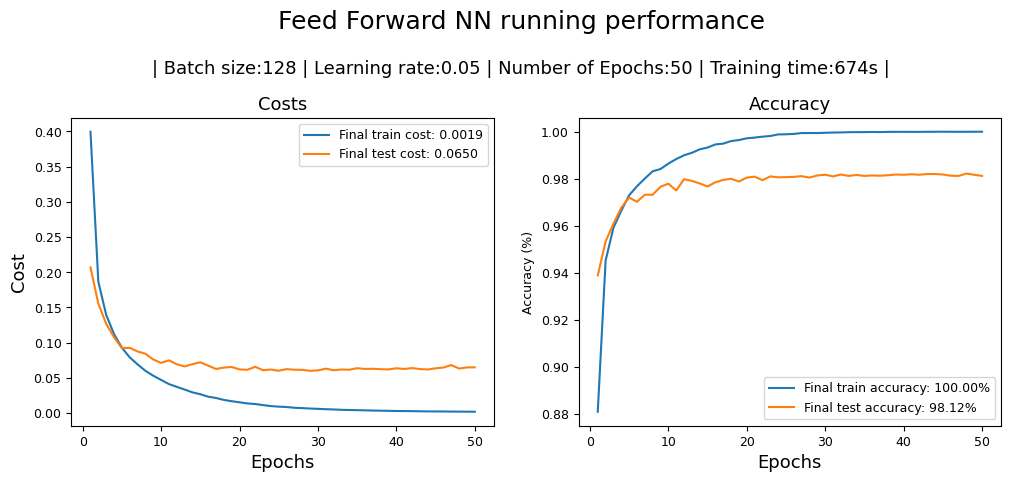

In [ ]:
training_curve_plot('Feed Forward NN running performance', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.05, EPOCHS, training_time)

**EXERCISE 2: MULTI LAYER CNN**

Network specification:
- Convolution, 8 times $3\times3\times1$ convolutions, stride=1, pad=1
- Relu Non-linearity
- Max Pooling, $2\times2$, stride=2
- Convolution, 16 times $3\times3\times8$ convolutions, stride=1, pad=1
- Relu Non-linearity
- Max Pooling, $2\times2$, stride=2
- Convolution, 32 times $3\times3\times16$ convolutions, stride=1, pad=1
- Relu Non-linearity
- FCN, 10 output neurons
- Softmax

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class multi_layer_cnn(nn.Module):
    def __init__(self):
        super(multi_layer_cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # after two max pooling, image size is 7x7
        self.fc1 = nn.Linear(7 * 7 * 32, 10)  # fully connected w 10 output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (batch_size, 8, 14, 14)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)  # (batch_size, 16, 7, 7)

        x = self.conv3(x)
        x = self.relu(x)

        # (batch_size, 32, 7, 7) -> (batch_size, 32*7*7)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x  # Logits (raw class scores)


In [8]:
import time

def train_sess(model, loss_fn, optimizer, EPOCHS, scheduler=None):
    train_costs = []
    test_costs = []
    train_accuracies = []
    test_accuracies = []
    start = time.time()
    model.to(device)

    for epoch in range(EPOCHS):
        epoch_start = time.time()  # Start timing this epoch

        print(f'EPOCH {epoch + 1}:')
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        num_batches = len(train_loader)  # batches per epoch

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

            if (i + 1) % 1000 == 0:  # Print every 1000 batches
                avg_batch_loss = running_loss / (i + 1)
                print(f'  Batch {i + 1}/{num_batches} - Loss: {avg_batch_loss:.4f}')

        # Compute final epoch loss and accuracy
        avg_loss = running_loss / num_batches if num_batches > 0 else 0
        train_accuracy = 100. * correct_train / total_train if total_train > 0 else 0
        train_costs.append(avg_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        running_vloss = 0.0
        correct_v = 0
        total_v = 0
        model.eval()
        with torch.no_grad():
            for vinputs, vlabels in test_loader:
                vinputs, vlabels = vinputs.to(device), vlabels.to(device)

                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()
                _, predicted = voutputs.max(1)
                correct_v += predicted.eq(vlabels).sum().item()
                total_v += vlabels.size(0)

        avg_vloss = running_vloss / len(test_loader) if len(test_loader) > 0 else 0
        test_costs.append(avg_vloss)
        test_accuracy = 100. * correct_v / total_v
        test_accuracies.append(test_accuracy)

        print(f'LOSS train {avg_loss:.4f} valid {avg_vloss:.4f}')
        print(f'Accuracy train {train_accuracy:.2f}% valid {test_accuracy:.2f}%')

        # Update the learning rate scheduler (if provided)
        if scheduler:
            scheduler.step()  # Update LR scheduler
            print(f"Epoch {epoch + 1}: Learning Rate = {scheduler.get_last_lr()[0]}")

        epoch_end = time.time()  # End timing this epoch
        print(f'Epoch {epoch + 1} took {epoch_end - epoch_start:.2f} seconds')

    end = time.time()  # End timing the entire training process
    print(f'Training completed in {end - start:.2f} seconds')
    training_time = end - start
    return train_costs, test_costs, train_accuracies, test_accuracies, training_time



In [ ]:
model = multi_layer_cnn()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
EPOCHS = 20
best_vloss = float('inf')
train_sess(model, loss_fn, optimizer, EPOCHS, scheduler)
training_time = end - start
training_curve_plot('CNN running performance', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.25, EPOCHS, training_time)

NameError: name 'multi_layer_cnn' is not defined

In [ ]:
learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of learnable parameters: {learnable_params}")


Total number of learnable parameters: 669706


**Exercise 3: Pooling before nonlin**
training time should be reduced.

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class multi_layer_cnn_switch(nn.Module):
    def __init__(self):
        super(multi_layer_cnn_switch, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        #self.nonlin = nn.ReLU()
        self.nonlin = nn.Tanh()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 32, 10)  # fully connected w 10 output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.nonlin(x)
        x = self.maxpool(x)  # (batch_size, 8, 14, 14)

        x = self.conv2(x)
        x = self.nonlin(x)
        x = self.maxpool(x)  # (batch_size, 16, 7, 7)

        x = self.conv3(x)
        x = self.nonlin(x)

        # (batch_size, 32, 7, 7) -> (batch_size, 32*7*7)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.softmax(x)

        return x


In [ ]:
model = multi_layer_cnn_switch()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model.to(device)
EPOCHS = 20
best_vloss = float('inf')
train_sess(model, loss_fn, optimizer, EPOCHS, scheduler)

multi_layer_cnn_switch(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (nonlin): Tanh()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

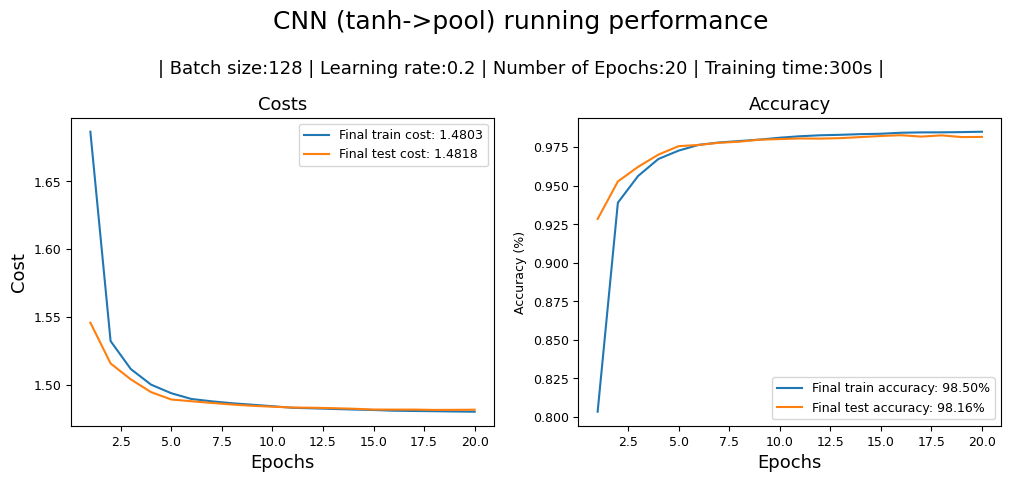

In [ ]:
training_time = end - start
training_curve_plot('CNN (tanh->pool) running performance', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.2, EPOCHS, training_time)

**Exercise 4 ADAM**

In [ ]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class multi_layer_cnn_adam(nn.Module):
    def __init__(self):
        super(multi_layer_cnn_adam, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        #self.nonlin = nn.ReLU()
        self.nonlin = nn.Tanh()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 32, 10)  # fully connected w 10 output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)  # (batch_size, 8, 14, 14)
        x = self.nonlin(x)

        x = self.conv2(x)
        x = self.maxpool(x)  # (batch_size, 16, 7, 7)
        x = self.nonlin(x)

        x = self.conv3(x)
        x = self.nonlin(x)

        # (batch_size, 32, 7, 7) -> (batch_size, 32*7*7)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.softmax(x)

        return x

In [ ]:
model = multi_layer_cnn_adam()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
model.to(device)
EPOCHS = 15
best_vloss = float('inf')
print(device)
train_sess(model, loss_fn, optimizer, 15)

cuda
EPOCH 1:
LOSS train 1.5990 valid 1.5164
Accuracy train 88.18% valid 95.06%
EPOCH 2:
LOSS train 1.5081 valid 1.4985
Accuracy train 95.84% valid 96.48%
EPOCH 3:
LOSS train 1.4936 valid 1.4878
Accuracy train 97.13% valid 97.47%
EPOCH 4:
LOSS train 1.4874 valid 1.4838
Accuracy train 97.66% valid 97.91%
EPOCH 5:
LOSS train 1.4833 valid 1.4811
Accuracy train 98.02% valid 98.18%
EPOCH 6:
LOSS train 1.4804 valid 1.4823
Accuracy train 98.27% valid 98.00%
EPOCH 7:
LOSS train 1.4783 valid 1.4783
Accuracy train 98.48% valid 98.37%
EPOCH 8:
LOSS train 1.4765 valid 1.4775
Accuracy train 98.65% valid 98.44%
EPOCH 9:
LOSS train 1.4754 valid 1.4765
Accuracy train 98.74% valid 98.57%
EPOCH 10:
LOSS train 1.4742 valid 1.4755
Accuracy train 98.85% valid 98.61%
EPOCH 11:
LOSS train 1.4730 valid 1.4776
Accuracy train 98.97% valid 98.41%
EPOCH 12:
LOSS train 1.4724 valid 1.4764
Accuracy train 99.00% valid 98.57%
EPOCH 13:
LOSS train 1.4713 valid 1.4759
Accuracy train 99.11% valid 98.56%
EPOCH 14:
LOSS t

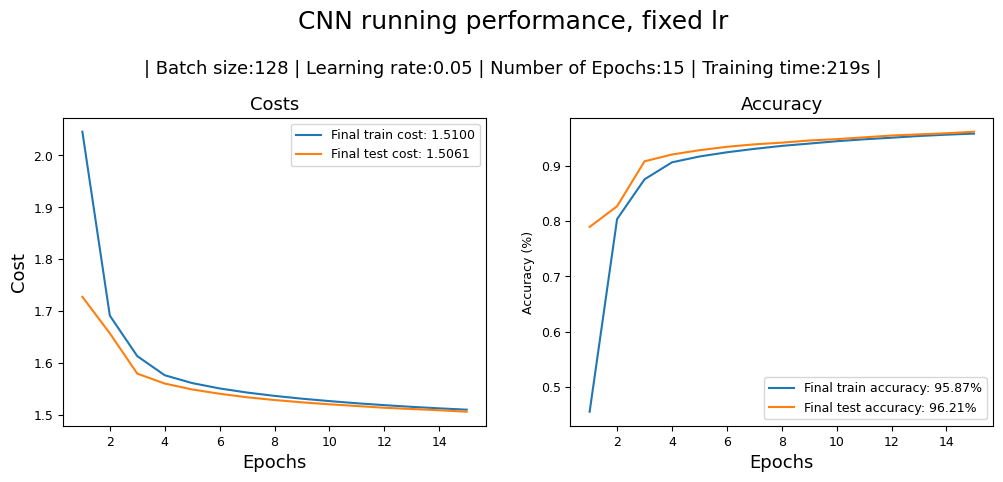

In [ ]:
training_time = end - start
training_curve_plot('CNN running performance, fixed lr', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.05, EPOCHS, training_time)

**Exercise 5: Residual connections**
...In particular, check if the inclusion of residual connections allows
training of deeper networks by replacing each convolution+activation pair in your architecture with a block of
two or three similar pairs, where the residual connection bridges over each such block.

In [ ]:
class model_v1(nn.Module):
    def __init__(self):
        super(model_v1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.nonlin = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 32, 10)  # fully connected w 10 output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.nonlin(x)
        x = self.maxpool(x)  # (batch_size, 8, 14, 14)
        x = self.conv2(x)
        x = self.nonlin(x)
        x = self.maxpool(x)  # (batch_size, 16, 7, 7)
        x = self.conv3(x)
        x = self.nonlin(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [ ]:
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(residual_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.nonlin = nn.ReLU()
        self.match_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = x  # skip connection
        x = self.conv1(x)
        x = self.nonlin(x)
        residual = self.match_channels(residual)  # ensure matching dim
        x = x + residual  # skip connection
        return x
#v2
class model_v2(nn.Module):
    def __init__(self):
        super(model_v2, self).__init__()
        self.res_block1 = residual_block(1, 8)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res_block2 = residual_block(8, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res_block3 = residual_block(16, 32)
        self.fc1 = nn.Linear(7 * 7 * 32, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # res block - pool - res block - pool - res block - fc - softmax
        x = self.res_block1(x)
        x = self.maxpool1(x)
        x = self.res_block2(x)
        x = self.maxpool2(x)
        x = self.res_block3(x)

        x = torch.flatten(x, 1)
        # classification
        x = self.fc1(x)
        x = self.softmax(x)

        return x


In [ ]:
model = model_v1()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
learning_rate = 0.25
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model.to(device)
EPOCHS = 20
best_vloss = float('inf')
train_costs, test_costs, train_accuracies, test_accuracies, training_time = train_sess(model, loss_fn, optimizer, EPOCHS, scheduler)

EPOCH 1:
LOSS train 1.8271 valid 1.6176
Accuracy train 64.02% valid 84.81%
Epoch 1: Learning Rate = 0.25
Epoch 1 took 17.90 seconds
EPOCH 2:
LOSS train 1.5991 valid 1.5856
Accuracy train 86.42% valid 87.58%
Epoch 2: Learning Rate = 0.25
Epoch 2 took 16.55 seconds
EPOCH 3:
LOSS train 1.5832 valid 1.5799
Accuracy train 87.84% valid 88.04%
Epoch 3: Learning Rate = 0.25
Epoch 3 took 16.36 seconds
EPOCH 4:
LOSS train 1.5779 valid 1.5819
Accuracy train 88.32% valid 87.85%
Epoch 4: Learning Rate = 0.25
Epoch 4 took 17.09 seconds
EPOCH 5:
LOSS train 1.5308 valid 1.4820
Accuracy train 93.16% valid 98.05%
Epoch 5: Learning Rate = 0.125
Epoch 5 took 16.39 seconds
EPOCH 6:
LOSS train 1.4815 valid 1.4809
Accuracy train 98.12% valid 98.11%
Epoch 6: Learning Rate = 0.125
Epoch 6 took 16.47 seconds
EPOCH 7:
LOSS train 1.4791 valid 1.4772
Accuracy train 98.35% valid 98.51%
Epoch 7: Learning Rate = 0.125
Epoch 7 took 16.65 seconds
EPOCH 8:
LOSS train 1.4774 valid 1.4774
Accuracy train 98.52% valid 98.47

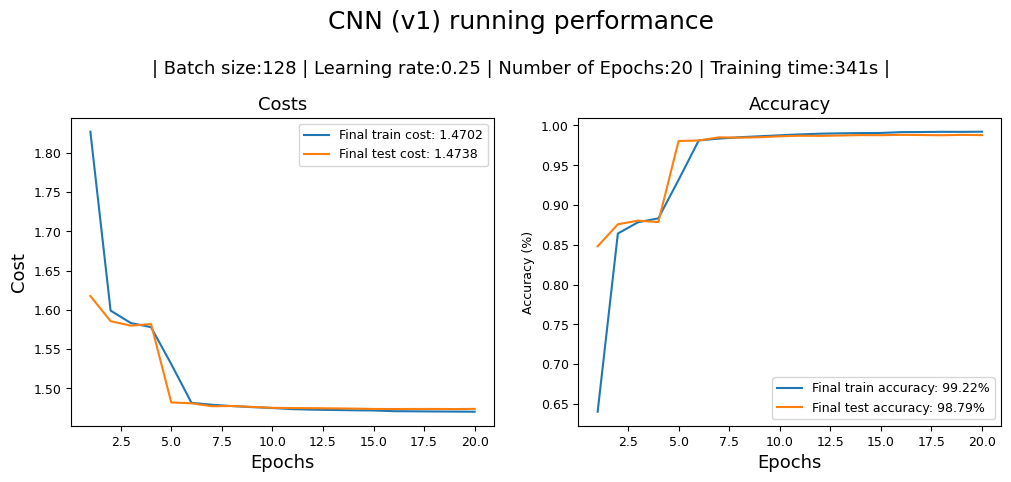

In [ ]:
training_curve_plot('CNN (v1) running performance', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.25, EPOCHS, training_time)

**Exercise 4: Three variations**

**Dropout**

EPOCH 1:
LOSS train 1.7501 valid 1.6199
Accuracy train 71.35% valid 84.12%
Epoch 1: Learning Rate = 0.25
Epoch 1 took 19.32 seconds
EPOCH 2:
LOSS train 1.6191 valid 1.5979
Accuracy train 84.33% valid 86.21%
Epoch 2: Learning Rate = 0.25
Epoch 2 took 20.00 seconds
EPOCH 3:
LOSS train 1.6003 valid 1.5859
Accuracy train 86.16% valid 87.42%
Epoch 3: Learning Rate = 0.25
Epoch 3 took 18.75 seconds
EPOCH 4:
LOSS train 1.5915 valid 1.5806
Accuracy train 87.01% valid 88.01%
Epoch 4: Learning Rate = 0.25
Epoch 4 took 19.92 seconds
EPOCH 5:
LOSS train 1.5092 valid 1.4871
Accuracy train 95.41% valid 97.52%
Epoch 5: Learning Rate = 0.125
Epoch 5 took 19.31 seconds
EPOCH 6:
LOSS train 1.4944 valid 1.4843
Accuracy train 96.82% valid 97.70%
Epoch 6: Learning Rate = 0.125
Epoch 6 took 20.02 seconds
EPOCH 7:
LOSS train 1.4931 valid 1.4813
Accuracy train 96.90% valid 98.07%
Epoch 7: Learning Rate = 0.125
Epoch 7 took 19.00 seconds
EPOCH 8:
LOSS train 1.4903 valid 1.4805
Accuracy train 97.21% valid 98.10

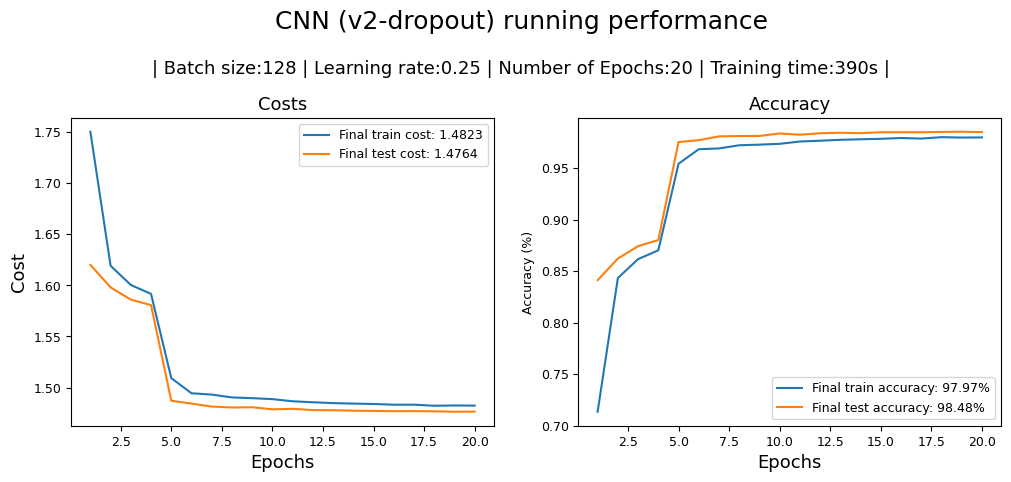

In [ ]:
class residual_dropout_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_rate=0.3):
        super(residual_dropout_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout2d(p=dropout_rate)  # drop out
        self.match_channels = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            if in_channels != out_channels else nn.Identity()
        )
    def forward(self, x):
        residual = x  # skip connection
        x = self.conv1(x)
        x = self.nonlin(x)
        x = self.dropout(x)  # drop out
        residual = self.match_channels(residual)  # ensure matching dim
        x = x + residual  # skip connection
        return x

class model_v2_dropout(nn.Module):
    def __init__(self):
        super(model_v2_dropout, self).__init__()
        self.res_block1 = residual_dropout_block(1, 8)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res_block2 = residual_dropout_block(8, 16)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.res_block3 = residual_dropout_block(16, 32)
        self.fc1 = nn.Linear(7 * 7 * 32, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # res block - pool - res block - pool - res block - fc - softmax
        x = self.res_block1(x)
        x = self.maxpool1(x)
        x = self.res_block2(x)
        x = self.maxpool2(x)
        x = self.res_block3(x)

        x = torch.flatten(x, 1)
        # classification
        x = self.fc1(x)
        x = self.softmax(x)

        return x
model = model_v2_dropout()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
learning_rate = 0.25
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model.to(device)
EPOCHS = 20
best_vloss = float('inf')
train_costs, test_costs, train_accuracies, test_accuracies, training_time = train_sess(model, loss_fn, optimizer, EPOCHS, scheduler)
training_curve_plot('CNN (v2-dropout) running performance', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.25, EPOCHS, training_time)


EPOCH 1:
LOSS train 1.7536 valid 1.5341
Accuracy train 71.14% valid 93.03%
Epoch 1: Learning Rate = 0.25
Epoch 1 took 15.34 seconds
EPOCH 2:
LOSS train 1.5094 valid 1.4923
Accuracy train 95.48% valid 96.95%
Epoch 2: Learning Rate = 0.25
Epoch 2 took 14.63 seconds
EPOCH 3:
LOSS train 1.4930 valid 1.4883
Accuracy train 97.00% valid 97.38%
Epoch 3: Learning Rate = 0.25
Epoch 3 took 14.60 seconds
EPOCH 4:
LOSS train 1.4860 valid 1.4815
Accuracy train 97.67% valid 98.05%
Epoch 4: Learning Rate = 0.25
Epoch 4 took 14.18 seconds
EPOCH 5:
LOSS train 1.4824 valid 1.4786
Accuracy train 97.95% valid 98.29%
Epoch 5: Learning Rate = 0.125
Epoch 5 took 15.34 seconds
EPOCH 6:
LOSS train 1.4779 valid 1.4780
Accuracy train 98.41% valid 98.33%
Epoch 6: Learning Rate = 0.125
Epoch 6 took 14.28 seconds
EPOCH 7:
LOSS train 1.4763 valid 1.4774
Accuracy train 98.56% valid 98.38%
Epoch 7: Learning Rate = 0.125
Epoch 7 took 15.28 seconds
EPOCH 8:
LOSS train 1.4750 valid 1.4757
Accuracy train 98.74% valid 98.60

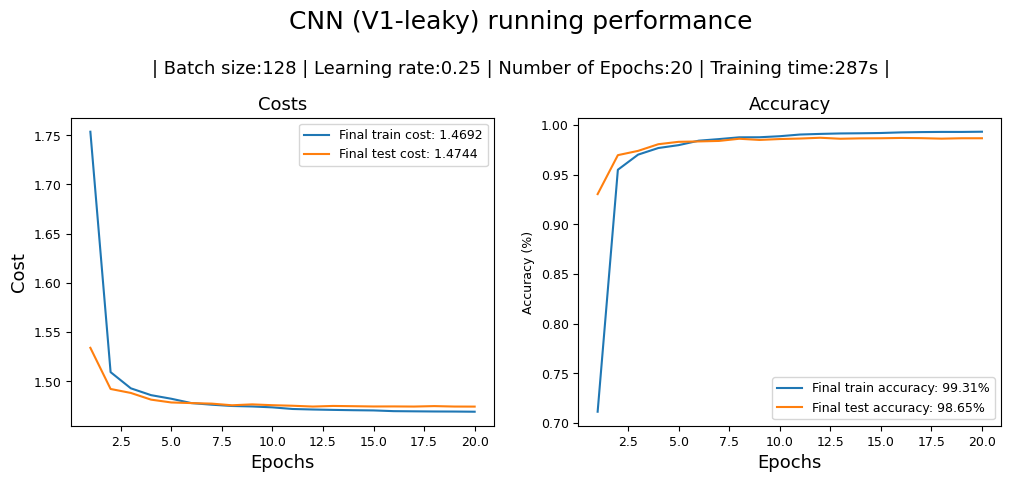

In [26]:
class model_v1_leaky(nn.Module):
    def __init__(self):
        super(model_v1_leaky, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.nonlin = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(7 * 7 * 32, 10)  # fully connected w 10 output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.nonlin(x)
        x = self.maxpool(x)  # (batch_size, 8, 14, 14)
        x = self.conv2(x)
        x = self.nonlin(x)
        x = self.maxpool(x)  # (batch_size, 16, 7, 7)
        x = self.conv3(x)
        x = self.nonlin(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

model = model_v1_leaky()
loss_fn = torch.nn.CrossEntropyLoss().to(device)
learning_rate = 0.25
optimizer = torch.optim.SGD(model.parameters(), lr=0.25)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
model.to(device)
EPOCHS = 20
best_vloss = float('inf')
train_costs, test_costs, train_accuracies, test_accuracies, training_time = train_sess(model, loss_fn, optimizer, EPOCHS, scheduler)
training_curve_plot('CNN (V1-leaky) running performance', train_costs, test_costs, train_accuracies, test_accuracies, batch_size, 0.25, EPOCHS, training_time)


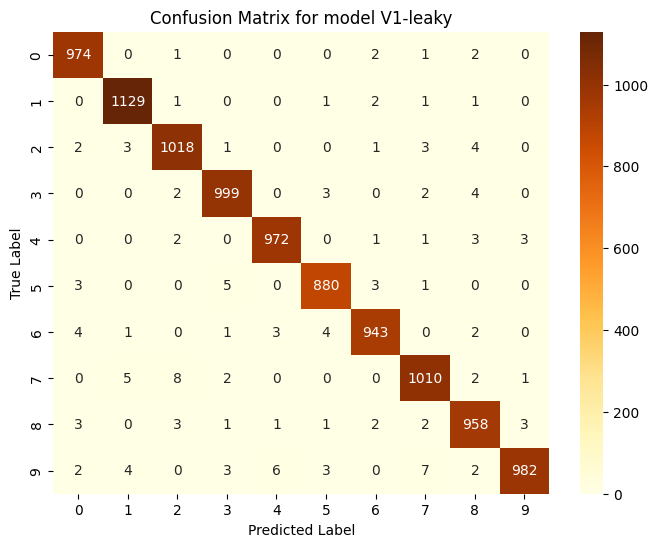

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
model.to(device)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# conf matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlOrBr", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for model V1-leaky")
plt.show()

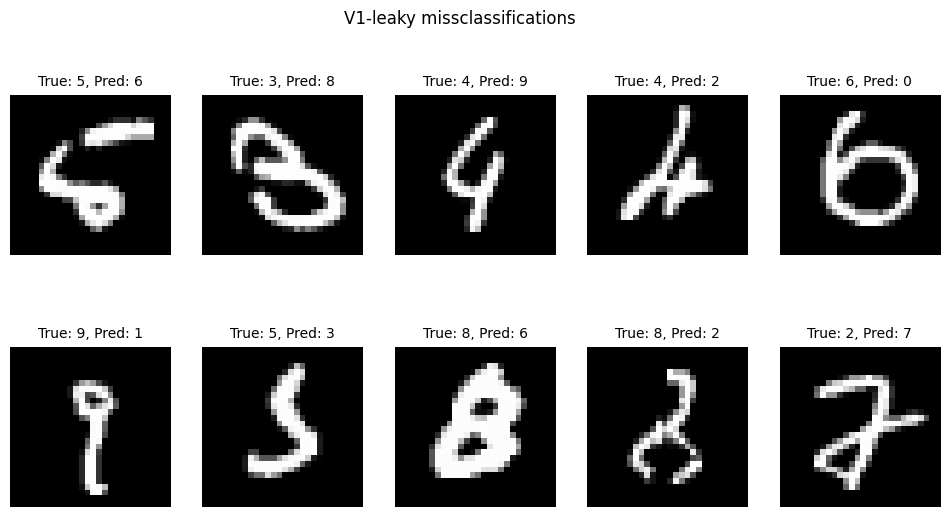

In [29]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        mis_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        for idx in mis_idx:
            misclassified.append((images[idx].cpu(), labels[idx].item(), predicted[idx].item()))

        if len(misclassified) >= 10:
            break

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, (img, true_label, pred_label) in enumerate(misclassified[:10]):
    img = img.squeeze().numpy()  # Convert tensor to numpy
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"True: {true_label}, Pred: {pred_label}", fontsize=10)
    axes[i].axis("off")

plt.suptitle("V1-leaky missclassifications")
plt.show()

